<a href="https://colab.research.google.com/github/eyllcyldrm/AlexNet-Cars-Prediction/blob/main/AlexNet-Cars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 3.1 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=cb15bf0db8c215866e3c55cdc320933926fb8dfe118af38e452ae575b4fd93eb
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [2]:
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"eyluleceyildirim","key":"017cea8ec6c8573926fbe9f1c581a3a9"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download -d jutrera/stanford-car-dataset-images-in-224x224

100% 2.45G/2.46G [00:30<00:00, 48.4MB/s]
100% 2.46G/2.46G [00:30<00:00, 87.4MB/s]


In [6]:
! mkdir car_data

In [7]:
! unzip stanford-car-dataset-images-in-224x224.zip -d car_data

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: car_data/stanford-car-dataset-by-classes-folder-224/stanford-car-dataset-by-classes-folder-224/car_data/train/Chrysler Aspen SUV 2009/04381.jpg  
  inflating: car_data/stanford-car-dataset-by-classes-folder-224/stanford-car-dataset-by-classes-folder-224/car_data/train/Chrysler Aspen SUV 2009/04688.jpg  
  inflating: car_data/stanford-car-dataset-by-classes-folder-224/stanford-car-dataset-by-classes-folder-224/car_data/train/Chrysler Aspen SUV 2009/04772.jpg  
  inflating: car_data/stanford-car-dataset-by-classes-folder-224/stanford-car-dataset-by-classes-folder-224/car_data/train/Chrysler Aspen SUV 2009/05544.jpg  
  inflating: car_data/stanford-car-dataset-by-classes-folder-224/stanford-car-dataset-by-classes-folder-224/car_data/train/Chrysler Aspen SUV 2009/05728.jpg  
  inflating: car_data/stanford-car-dataset-by-classes-folder-224/stanford-car-dataset-by-classes-folder-224/car_data/train/Chrysler Aspen SUV 2009/05860.jpg  

In [8]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import glob
import cv2

In [9]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPool2D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD


In [10]:
names = pd.read_csv('car_data/stanford-car-dataset-by-classes-folder-224/stanford-car-dataset-by-classes-folder-224/names.csv')
names = names.values

In [11]:
np.random.shuffle(names)

In [12]:
nr_cars = 10

In [13]:
idx_to_name = {x:names[x][0] for x in np.arange(nr_cars)}
name_to_idx = {x:i for i,x in enumerate(idx_to_name.values())}

In [14]:
idx_to_name

{0: 'Ram C/V Cargo Van Minivan 2012',
 1: 'Acura ZDX Hatchback 2012',
 2: 'Suzuki Kizashi Sedan 2012',
 3: 'Hyundai Accent Sedan 2012',
 4: 'Audi A5 Coupe 2012',
 5: 'BMW X6 SUV 2012',
 6: 'Hyundai Azera Sedan 2012',
 7: 'Buick Verano Sedan 2012',
 8: 'Lincoln Town Car Sedan 2011',
 9: 'BMW X3 SUV 2012'}

In [15]:
train_path = 'car_data/stanford-car-dataset-by-classes-folder-224/stanford-car-dataset-by-classes-folder-224/car_data/train/'
test_path = 'car_data/stanford-car-dataset-by-classes-folder-224/stanford-car-dataset-by-classes-folder-224/car_data/test/'


In [16]:
def get_data(path):
    train = []
    for i, name in enumerate(name_to_idx.keys()):
        new_path = path + name + "/"
        [train.append([i, cv2.resize(cv2.imread(img), (244,244), interpolation = cv2.INTER_AREA)]) for img in glob.glob(new_path + "*.jpg")]
    return np.array(train)

In [17]:
train = get_data(train_path)
test = get_data(test_path)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [18]:
X_train = np.concatenate(train[:,1], axis=0).reshape(len(train), 244, 244, 3)
X_train = X_train / 255.0
X_train = X_train.astype('float32')
y_train = train[:,0]
y_train = np.eye(len(idx_to_name))[list(y_train)]

X_test = np.concatenate(test[:,1], axis=0).reshape(len(test), 244, 244, 3)
X_test = X_test / 255.0
X_test = X_test.astype('float32')
y_test = test[:,0]
y_test = np.eye(len(idx_to_name))[list(y_test)]

In [19]:
# Instantiate an empty sequential model
model = Sequential(name="Alexnet")
# 1st layer (conv + pool + batchnorm)
model.add(Conv2D(filters= 96, kernel_size= (11,11), strides=(4,4), padding='valid', kernel_regularizer=l2(0.0005),
input_shape = (227,227,3)))
model.add(Activation('relu'))  #<---- activation function can be added on its own layer or within the Conv2D function
model.add(MaxPool2D(pool_size=(3,3), strides= (2,2), padding='valid'))
model.add(BatchNormalization())
    
# 2nd layer (conv + pool + batchnorm)
model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same', kernel_regularizer=l2(0.0005)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid'))
model.add(BatchNormalization())
            
# layer 3 (conv + batchnorm)      <--- note that the authors did not add a POOL layer here
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', kernel_regularizer=l2(0.0005)))
model.add(Activation('relu'))
model.add(BatchNormalization())
        
# layer 4 (conv + batchnorm)      <--- similar to layer 3
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', kernel_regularizer=l2(0.0005)))
model.add(Activation('relu'))
model.add(BatchNormalization())
            
# layer 5 (conv + batchnorm)  
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', kernel_regularizer=l2(0.0005)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid'))

# Flatten the CNN output to feed it with fully connected layers
model.add(Flatten())

# layer 6 (Dense layer + dropout)  
model.add(Dense(units = 4096, activation = 'relu'))
model.add(Dropout(0.5))

# layer 7 (Dense layers) 
model.add(Dense(units = 4096, activation = 'relu'))
model.add(Dropout(0.5))
                           
# layer 8 (softmax output layer) 
model.add(Dense(units = len(y_train[0]), activation = 'softmax'))

# print the model summary
model.summary()

Model: "Alexnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
activation (Activation)      (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
activation_1 (Activation)    (None, 27, 27, 256)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 256)       0   

In [20]:
# reduce learning rate by 0.1 when the validation error plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1))
 
# set the SGD optimizer with lr of 0.01 and momentum of 0.9
optimizer = SGD(lr = 0.01, momentum = 0.9)
 
# compile the model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [21]:
# train the model
# call the reduce_lr value using callbacks in the training method
with tf.device('/GPU:0'):
    history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test),
    verbose=0, callbacks=[reduce_lr])

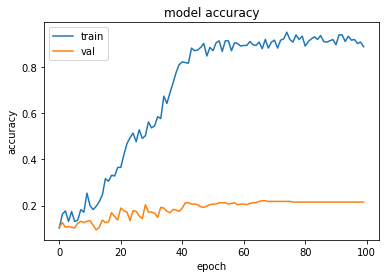

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

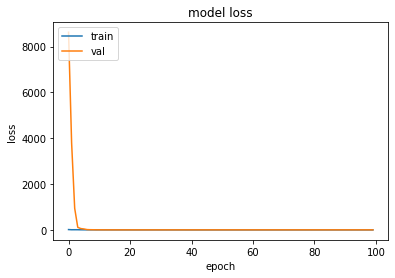

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [24]:
def predict(img):
    to_predict = np.zeros(shape=X_train.shape)
    to_predict[0] = img
    
    return idx_to_name[np.argmax(model(to_predict)[0])]

In [27]:
predict(X_test[91])

'Hyundai Accent Sedan 2012'

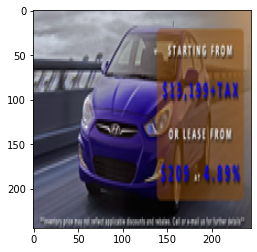

In [28]:
plt.imshow(X_test[91])